In [1]:
import pandas as pd
#from Utils import get_features
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
%cd gdrive/MyDrive/frozenSuite_Nov9-2

# Final_Data2

/content/gdrive/MyDrive/frozenSuite_Nov9-2


In [4]:
X_train = np.load('input.npy',allow_pickle=True)
y_train = np.load('answers.npy',allow_pickle=True)

In [ ]:
X_train = np.load('X_train_full.npy',allow_pickle=True)
y_train = np.load('y_train_full.npy',allow_pickle=True)
X_test = np.load('X_test_full.npy',allow_pickle=True)
y_test = np.load('y_test_full.npy',allow_pickle=True)

In [ ]:
%cd ..

/content/gdrive/My Drive/frozenSuite_Nov9-2


In [ ]:
ls

answers.py             MyModel_V1.pt               XGGradBoost.pkl
checkpoint.pt          New_Data/                   X_test_full.npy
Data_large/            __pycache__/                X_test.npy
dennyCode_modified.py  QAfeatures.py               X_train_full.npy
dev-v2.0.json          Testing_the_Code.ipynb      X_train.npy
Final_data/            Training_SQUADCollab.ipynb  y_test_full.npy
Final_Data2/           Utils.py                    y_test.npy
GradBoost.pkl          XGBoost_Test.ipynb          y_train_full.npy
lincoln.txt            XGGradBoost_41.pkl          y_train.npy
messi.txt              XGGradBoost_425.pkl
Models/                XGGradBoost_43.pkl


In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[-1])

In [ ]:
X_test_flat = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[-1])

In [ ]:
X_train_flat.shape

(20609, 300)

In [ ]:
y_train.shape

(20609, 30)

In [ ]:
class_labels = np.argmax(y_train, axis=1) # assuming you have n-by-5 class_prob

In [ ]:
y_test_classes = np.argmax(y_test, axis=1) # assuming you have n-by-5 class_prob

## Trying to use KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()



knn.fit(X_train_flat,class_labels)

KNeighborsClassifier()

In [ ]:
preds = knn.predict(X_train_flat)

In [ ]:
sum(class_labels==preds)/len(preds)

0.3317497103128621

In [ ]:
len(preds)

18240

# Now trying to use SVM

In [ ]:
from sklearn import svm

svc = svm.SVC(kernel='rbf')

svc.fit(X_train_flat,class_labels)

SVC()

In [ ]:
preds = svc.predict(X_train_flat)

acc = sum(class_labels==preds)/len(preds)

print(f'Support Vector Machine with RBF kernel has an accuracy of {acc}')

Support Vector Machine with RBF kernel has an accuracy of 0.28273026315789473


In [ ]:
svc = svm.SVC(kernel='poly',
...               degree=3)

svc.fit(X_train_flat,class_labels)

SVC(kernel='poly')

In [ ]:
preds = svc.predict(X_train_flat)

acc = sum(class_labels==preds)/len(preds)

print(f'Support Vector Machine with Poly (degree=3) kernel has an accuracy of {acc}')

Support Vector Machine with Poly (degree=3) kernel has an accuracy of 0.21710526315789475


## Trying Ensemble methods + others

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train_flat,class_labels)
predictors=list(X_train_flat)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test_flat, y_test_classes)))

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4, cv=5,verbose=10)
tuning.fit(X_train_flat,class_labels)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: ignored

In [ ]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5,verbose=10)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

In [ ]:
print('IT WORKED')

IT WORKED


In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_flat,class_labels)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test_flat)
    acc = accuracy_score(y_test_classes, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test_flat)
    ll = log_loss(y_test_classes, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 9.3926%
Log Loss: 27.319231536239712
SVC
****Results****
Accuracy: 3.3379%
Log Loss: 3.1717920251599763
NuSVC
****Results****
Accuracy: 12.1483%
Log Loss: 2.817022282033627
DecisionTreeClassifier
****Results****
Accuracy: 16.0877%
Log Loss: 28.98227617535299
RandomForestClassifier
****Results****
Accuracy: 24.3159%
Log Loss: 2.885466849898143
AdaBoostClassifier
****Results****
Accuracy: 22.0260%
Log Loss: 3.3718966650702904
GradientBoostingClassifier
****Results****
Accuracy: 41.3157%
Log Loss: 1.8638271671254412
GaussianNB
****Results****
Accuracy: 16.6311%
Log Loss: 7.698055610587122
LinearDiscriminantAnalysis
****Results****
Accuracy: 35.7462%
Log Loss: 2.1553740809685045


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Results****
Accuracy: 22.1036%
Log Loss: 21.98866185376923


In [ ]:
grad_boost = GradientBoostingClassifier(tol=0.0001,max_depth=5,n_estimators=300)

grad_boost.fit(X_train_flat,class_labels)

train_predictions = grad_boost.predict(X_train_flat)
acc = accuracy_score(class_labels, train_predictions)
print("Accuracy: {:.4%}".format(acc))

train_predictions = grad_boost.predict_proba(X_train_flat)
ll = log_loss(class_labels, train_predictions)
print("Log Loss: {}".format(ll))

Accuracy: 100.0000%
Log Loss: 0.07867225912252936


In [ ]:
train_predictions = grad_boost.predict(X_test_flat)
acc = accuracy_score(y_test_classes, train_predictions)
print("Accuracy: {:.4%}".format(acc))

train_predictions = grad_boost.predict_proba(X_test_flat)
ll = log_loss(y_test_classes, train_predictions)
print("Log Loss: {}".format(ll))

In [ ]:
import pickle

with open('XGGradBoost_43.pkl','rb') as f:
  x = pickle.load(f)

In [ ]:
x.save_model('XGBoost.model')

In [5]:
import xgboost as xgb

XGB = xgb.Booster()
XGB.load_model('XGBoost.model')

In [7]:
y_train[0]

"[Lincoln, Lincoln, Ulysses S. Grant, late 1863, Springfield, Lincoln, several years, about 18 months, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']"

In [ ]:
class_labels[4]

22

In [ ]:
np.argmax(XGB.predict(xgb.DMatrix(X_train_flat[4].reshape(1,300))))

22

In [ ]:
xgb.__version__

'0.90'

In [ ]:
y_test_classes[5]

15

In [ ]:
x.predict(X_test_flat[5].reshape(1,300))

array([19])

In [ ]:
X_test_flat.shape

(4560, 300)

In [ ]:
pwd

'/content/gdrive/My Drive/frozenSuite_Nov9-2'

In [ ]:
import pickle 

filename='GradBoost2.pkl'

pickle.dump(grad_boost,open(filename,'wb'))



In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_flat,class_labels)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_train_flat)
    acc = accuracy_score(class_labels, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_train_flat)
    ll = log_loss(class_labels, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 41.0471%
Log Loss: 0.9828932351101033
SVC
****Results****
Accuracy: 3.5746%
Log Loss: 3.2013458742621013
NuSVC
****Results****
Accuracy: 38.5252%
Log Loss: 2.141339256590484
DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
Log Loss: 2.975827430477583e-14
RandomForestClassifier
****Results****
Accuracy: 100.0000%
Log Loss: 0.4043954166043435
AdaBoostClassifier
****Results****
Accuracy: 22.8070%
Log Loss: 3.372630367603747
GradientBoostingClassifier
****Results****
Accuracy: 69.8136%
Log Loss: 1.2496333754228366
GaussianNB
****Results****
Accuracy: 18.9254%
Log Loss: 6.772694112696107
LinearDiscriminantAnalysis
****Results****
Accuracy: 45.1480%
Log Loss: 1.849144365920137


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Results****
Accuracy: 97.8454%
Log Loss: 0.511919646112973


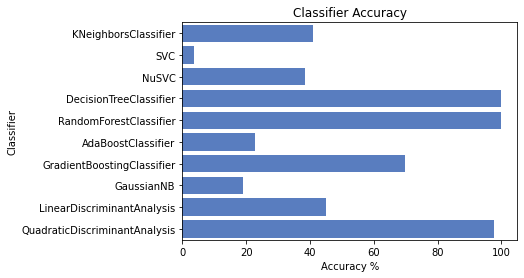

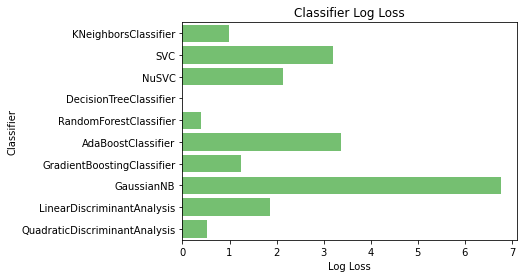

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

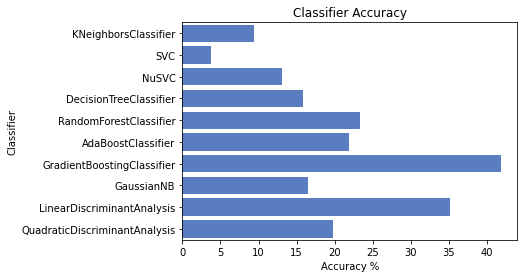

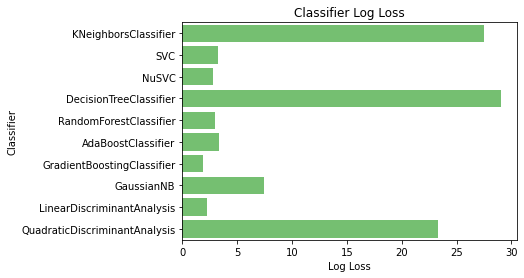

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

## Trying CatBoost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 46 kB/s 


In [ ]:
cat_features = [0]

In [ ]:
from catboost import CatBoostClassifier, Pool
import pandas as pd

data = pd.DataFrame({'string_column': ['val0', 'val1', 'val2'],
                     'int_column': [1,2,3],
                     'float_column': [1.2,2,4.1]})

In [ ]:
clf = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.1, 
    loss_function='MultiClass'
    #loss_function='CrossEntropy'
)


clf.fit(X_train_flat, class_labels.astype(int), # class_labels
        cat_features=cat_features, 
        eval_set=(X_test_flat,y_test_classes.astype(int)), 
        verbose=False
)

CatBoostError: ignored

In [ ]:
class_labels[0]

10

In [ ]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [ ]:
scores = cross_val_score(XGBRegressor(objective='reg:squarederror'),X_train_flat,class_labels,scoring='neg_mean_squared_error')

In [ ]:
RMSE = (-scores)**0.5

In [ ]:
print(RMSE)

[8.19921316 8.156035   8.10529819 8.20195227 8.18412039]


In [ ]:
xg_reg = XGBRegressor(objective ='multi:softprob',num_class=30,max_depth=15)
# xgb_options['objective'] = 'multi:softprob'
#             xgb_options['num_class'] = self.n_classes_

In [ ]:

xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train_flat,y_train)

preds = xg_reg.predict(X_test_flat)

In [ ]:
train_preds = xg_reg.predict(X_train_flat)

In [ ]:
np.argmax(y_train[0])

10

In [ ]:
train_preds[10]

array([4.3167451e-01, 5.6297570e-01, 1.9106282e-04, 1.9106282e-04,
       1.9106282e-04, 1.9106282e-04, 1.9106282e-04, 1.9106282e-04,
       1.9106282e-04, 1.9106282e-04, 1.9106282e-04, 1.9106282e-04,
       1.9106282e-04, 1.9106282e-04, 1.9106282e-04, 1.9106282e-04,
       1.9106282e-04, 1.9106282e-04, 1.9106282e-04, 1.9106282e-04,
       1.9106282e-04, 1.9106282e-04, 1.9106282e-04, 1.9106282e-04,
       1.9106282e-04, 1.9106282e-04, 1.9106282e-04, 1.9106282e-04,
       1.9106282e-04, 1.9106282e-04], dtype=float32)

In [ ]:
np.argmax(train_preds[0])

0

In [ ]:
preds.round()

array([13., 15., 16., ..., 15., 13., 19.], dtype=float32)

In [ ]:
y_test_classes

array([25, 10,  1, ..., 27,  5, 14])

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_classes, preds))

ValueError: ignored

In [ ]:
count = len(train_preds)
correct = 0
incorrect = 0
for i,pred in enumerate(train_preds.round()):
  if class_labels[i]==pred:
    correct+=1
  else:
    incorrect+=1

acc = correct/count

In [ ]:
count = len(preds)
correct = 0
incorrect = 0
for i,pred in enumerate(preds.round()):
  if y_test_classes[i]==pred:
    correct+=1
  else:
    incorrect+=1

acc = correct/count

In [ ]:
acc

0.03245614035087719

In [ ]:
acc

0.03300438596491228

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
xgb = XGBClassifier(tree_method='gpu_hist')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Get columns list for categorical and numerical

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', XGBClassifier(tree_method='gpu_hist',verbose=3))
])



In [ ]:


n_samples = len(train_df)
halving_results_n_samples =\
    HalvingGridSearchCV(resource='n_samples',
                        min_resources=n_samples//\
                        MAX_RESOURCE_DIVISOR,
                        factor=FACTOR,
                        **grid_search_params
                        )\
                        .fit(train_df, y_train)

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform




# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [50, 100, 150, 200,250],
    'clf__learning_rate': [0.0001,0.001,0.01, 0.1, 0.2],
    'clf__max_depth': range(3, 10),
    #'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    #'clf__gamma': [i/10.0 for i in range(3)],
    'fs__k': [10],
  }
]

# distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])

# Define cross validation
kfold = KFold(n_splits=3, random_state=42,shuffle=True)
# AUC and accuracy as score
scoring = {'Accuracy':make_scorer(accuracy_score)}
# Define grid search GridSearchCV
grid =  GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='Accuracy',
  verbose=10,
  n_jobs=1
)
# Fit grid search
model = grid.fit(X_train_flat, class_labels)

Fitting 3 folds for each of 175 candidates, totalling 525 fits
[CV 1/3; 1/175] START clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=50, fs__k=10
[CV 1/3; 1/175] END clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=50, fs__k=10; Accuracy: (test=0.118) total time=   7.6s
[CV 2/3; 1/175] START clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=50, fs__k=10
[CV 2/3; 1/175] END clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=50, fs__k=10; Accuracy: (test=0.117) total time=   7.5s
[CV 3/3; 1/175] START clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=50, fs__k=10
[CV 3/3; 1/175] END clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=50, fs__k=10; Accuracy: (test=0.122) total time=   7.5s
[CV 1/3; 2/175] START clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=100, fs__k=10
[CV 1/3; 2/175] END clf__learning_rate=0.0001, clf__max_depth=3, clf__n_estimators=100, fs__k=10; Accuracy: (test=0.119) total 

In [ ]:
print(model.best_params_)

{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'fs__k': 10}


In [ ]:
predict = model.predict(X_test_flat)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_classes, predict)))
print(confusion_matrix(y_test_classes,predict))


Best AUC Score: 0.12141382868937049
Accuracy: 0.11929824561403508


NameError: ignored

In [ ]:
import pickle 

filename='XGGradBoost.pkl'

pickle.dump(model,open(filename,'wb'))

In [ ]:
import xgboost as xgb

X, y = X_train_flat,class_labels
dmatrix = xgb.DMatrix(data=X, label=y)
params={ 'objective':'reg:squarederror',
         'max_depth': 6, 
         'colsample_bylevel':0.5,
         'learning_rate':0.01,
         'random_state':20}
cv_results = xgb.cv(dtrain=dmatrix, params=params, verbose=3,nfold=10, metrics={'rmse'}, as_pandas=True, seed=20, num_boost_round=1000)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

TypeError: ignored

xgb_cl = XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=150,verbosity=3,reg_alpha=.2,tree_method='gpu_hist',colsample_bytree=.7,subsample=0.95) --> .41082


0.4108187134502924


xgb_cl = XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=150,verbosity=3,reg_alpha=.2,tree_method='gpu_hist',colsample_bytree=.75,subsample=0.95,gamma=5) - 0.411111*

In [ ]:
eval_set = [(X_train_flat, class_labels),(X_test_flat, y_test_classes)]
eval_metric = ["merror"]
# Init classifier
xgb_cl = XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=150,verbosity=3,reg_alpha=.2,tree_method='gpu_hist',colsample_bytree=.75,subsample=0.95,gamma=5)


%time xgb_cl.fit(X_train_flat, class_labels, eval_metric=eval_metric, eval_set=eval_set, verbose=True,early_stopping_rounds=10)


[0]	validation_0-merror:0.702993	validation_1-merror:0.732164
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.660062	validation_1-merror:0.689474
[2]	validation_0-merror:0.634365	validation_1-merror:0.676316
[3]	validation_0-merror:0.617028	validation_1-merror:0.672515
[4]	validation_0-merror:0.604128	validation_1-merror:0.656725
[5]	validation_0-merror:0.595459	validation_1-merror:0.653509
[6]	validation_0-merror:0.588906	validation_1-merror:0.648246
[7]	validation_0-merror:0.580495	validation_1-merror:0.647661
[8]	validation_0-merror:0.572755	validation_1-merror:0.64883
[9]	validation_0-merror:0.568215	validation_1-merror:0.645322
[10]	validation_0-merror:0.566254	validation_1-merror:0.641228
[11]	validation_0-merror:0.562177	validation_1-merror:0.639766
[12]	validation_0-merror:0.559236	validation_1-merror:0.632456
[13]	validation_0-merror:0.55

XGBClassifier(colsample_bytree=0.75, gamma=5, n_estimators=150,
              objective='multi:softprob', reg_alpha=0.2, subsample=0.95,
              tree_method='gpu_hist', verbosity=3)

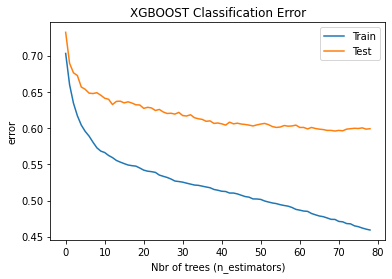

In [ ]:
from matplotlib import pyplot as plt
# Evaluation results
evaluation_results = xgb_cl.evals_result_
err_train = evaluation_results['validation_0']['merror'] # Train ‘error’ metric
err_test = evaluation_results['validation_1']['merror'] # Test ‘error’ metric
# Plotting ‘XGBOOST Classification Error’ 
plt.plot(err_train)
plt.plot(err_test)
plt.xlabel('Nbr of trees (n_estimators)')
plt.ylabel('error')
plt.legend(['Train', 'Test'])
plt.title('XGBOOST Classification Error')
plt.show()

[19:55:35] ======== Monitor: Learner ========
[19:55:35] WARNING: /workspace/src/common/././timer.h:69: Timer for EvalOneIter did not get stopped properly.
[19:55:35] GetGradient: 0.000652277s, 1 calls @ 652us
[19:55:35] PredictRaw: 0.000295888s, 1 calls @ 295us
[19:55:35] UpdateOneIter: 0.501666s, 1 calls @ 501666us
[19:55:35] ======== Monitor: GBTree ========
[19:55:35] BoostNewTrees: 0.47094s, 1 calls @ 470940us
[19:55:35] CommitModel: 0.0297699s, 1 calls @ 29769us
[19:55:35] ======== Monitor:  ========
[19:55:35] DevicePredictInternal: 0.0293601s, 3 calls @ 9786us
[19:55:35] PredictFromCache: 0.000205784s, 1 calls @ 205us
[19:55:35] ======== Monitor: updater_gpu_hist ========
[19:55:35] BinningCompression: 0.0124875s, 1 calls @ 12487us
[19:55:35] InitData: 0.251953s, 30 calls @ 8398us
[19:55:35] InitDataOnce: 0.251943s, 1 calls @ 251943us
[19:55:35] Quantiles: 0.231495s, 1 calls @ 231494us
[19:55:35] Update: 0.462695s, 30 calls @ 15423us
[19:55:35] ======== NCCL Statistics========


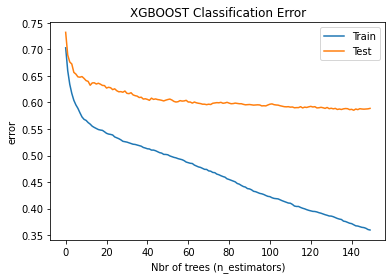

In [ ]:
from matplotlib import pyplot as plt
# Evaluation results
evaluation_results = xgb_cl.evals_result_
err_train = evaluation_results['validation_0']['merror'] # Train ‘error’ metric
err_test = evaluation_results['validation_1']['merror'] # Test ‘error’ metric
# Plotting ‘XGBOOST Classification Error’ 
plt.plot(err_train)
plt.plot(err_test)
plt.xlabel('Nbr of trees (n_estimators)')
plt.ylabel('error')
plt.legend(['Train', 'Test'])
plt.title('XGBOOST Classification Error')
plt.show()

In [ ]:
xgb.__version__

'0.90'

In [ ]:
X_test_flat.shape[0]*X_test_flat.shape[1]

1026000

In [ ]:
X_test_flat.shape

(3420, 300)

In [ ]:
y_test_classes.shape

(3420,)

In [ ]:
class_labels.shape

(19380,)

In [ ]:
X_train_flat.shape

(19380, 300)

## Try using PCA

In [ ]:
xfill=np.full(10,0)
for i,array in enumerate(x_reshaped):
  if np.all(array==-1):
    x_reshaped[i] = xfill



In [ ]:
for i,array in enumerate(x_test_reshaped):
  if np.all(array==-1):
    x_test_reshaped[i] = xfill

In [ ]:
x_test_zeros = x_test_reshaped.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

In [ ]:
x_zeros = x_reshaped.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])

In [ ]:
X_train.shape

(19380, 30, 10)

In [ ]:
x_reshaped = X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2])

In [ ]:
x_reshaped.shape

(581400, 10)

In [ ]:
x_test_reshaped = X_test.reshape(X_test.shape[0]*X_test.shape[1],X_test.shape[2])

In [ ]:
from sklearn.preprocessing import StandardScaler
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']

# Standardizing the features
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_reshaped)

x = scaler.transform(x_reshaped)
x_test = scaler.transform(x_test_reshaped)

# x = StandardScaler().fit_transform(X_train_flat)
# x_test = StandardScaler().fit_transform(X_test_flat)

In [ ]:
x_norm = x.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
x_test_norm = x_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(x)

PCA(n_components=2)

In [ ]:
xxx=np.array([[-1,-1,-1],[1,1,1]])

xfill=np.full(10,0)
xxx[0] = xfill

In [ ]:
xxx

array([[0, 0, 0],
       [1, 1, 1]])

In [ ]:
np.all(np.array([-1,-1,-1])==-1)

True

In [ ]:
#x_test = StandardScaler().fit_transform(X_test_flat)
x_train = pca.transform(x)
x_test = pca.transform(x_test)

In [ ]:
X_train_PCA = x_train.reshape(X_train.shape[0],X_train.shape[1]*x_train.shape[1])

In [ ]:
X_test_PCA = x_test.reshape(X_test.shape[0],X_test.shape[1]*x_test.shape[1])

In [ ]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=150,verbosity=3,reg_alpha=.2,tree_method='gpu_hist',colsample_bytree=.75,subsample=0.95,gamma=10,rate_drop=.5)

# Fit
xgb_cl.fit(x_zeros, class_labels)

# Predict
preds = xgb_cl.predict(x_test_zeros)

# Score
accuracy_score(y_test_classes, preds)

0.40906432748538013

## Training XGBoost

In [ ]:
import pickle
with open('GradBoost.pkl','rb') as f:
  x = pickle.load(f)

In [ ]:
# Predict
preds = x.predict(X_test_flat)

# Score
accuracy_score(y_test_classes, preds)

0.35627425614489006

In [ ]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = XGBClassifier(max_depth=3,learning_rate=0.2,n_estimators=200,verbosity=3,reg_alpha=.2,tree_method='gpu_hist',colsample_bytree=.75,subsample=0.95,gamma=10,rate_drop=.5)

# Fit
xgb_cl.fit(X_train_flat, class_labels)

# Predict
preds = xgb_cl.predict(X_test_flat)

# Score
accuracy_score(y_test_classes, preds)

0.40496353799106094

In [ ]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=200,verbosity=3,reg_alpha=.2,tree_method='gpu_hist',colsample_bytree=.75,subsample=0.95,gamma=10,rate_drop=.5)

# Fit
xgb_cl.fit(X_train_flat, class_labels)

# Predict
preds = xgb_cl.predict(X_test_flat)

# Score
accuracy_score(y_test_classes, preds)

0.42693576557345236

In [ ]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=150,verbosity=3,reg_alpha=.2,tree_method='gpu_hist',colsample_bytree=.75,subsample=0.95,gamma=10,rate_drop=.5)

# Fit
xgb_cl.fit(X_train_flat, class_labels)

# Predict
preds = xgb_cl.predict(X_test_flat)

# Score
accuracy_score(y_test_classes, preds)

0.40906432748538013

In [ ]:
import pickle 

filename='XGGradBoost_43.pkl'

pickle.dump(xgb_cl,open(filename,'wb'))

In [ ]:
"dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")


X = dataset[:,0:8]
Y = dataset[:,8]

SyntaxError: ignored

In [ ]:
# Predict
preds = xgb_cl.predict(X_test_flat)

# Score
accuracy_score(y_test_classes, preds)

0.404093567251462

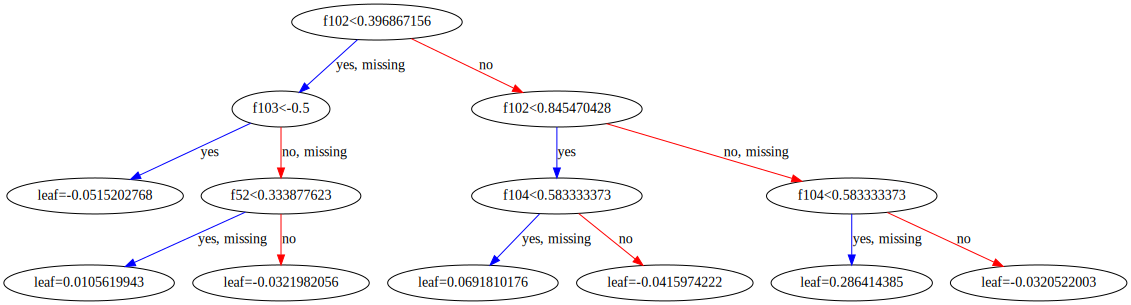

In [ ]:
xgb.to_graphviz(xgb_cl, num_trees=40)

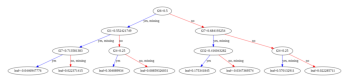

In [ ]:
xgb.plot_tree(xgb_cl, num_trees=2)

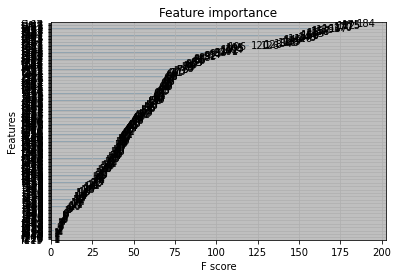

In [ ]:
xgb.plot_importance(xgb_cl)